In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Data processing.

## Use Taxi Datasets.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        time_seqs = [event["time_since_start"] for event in sequence]
        time_delta_seqs = [event["time_since_last_event"] for event in sequence]
        type_seqs = [event["type_event"] for event in sequence]

        return {
            'time_seqs': torch.tensor(time_seqs, dtype=torch.float32),
            'time_delta_seqs': torch.tensor(time_delta_seqs, dtype=torch.float32),
            'type_seqs': torch.tensor(type_seqs, dtype=torch.long),
        }


def load_pkl(file_path, split="train"):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data[split]  # 提取事件序列列表


def pad_collate_fn(batch):
    max_len = max(len(sample['time_seqs']) for sample in batch)

    padded_time_seqs = torch.zeros(len(batch), max_len, dtype=torch.float32)
    padded_time_delta_seqs = torch.zeros(len(batch), max_len, dtype=torch.float32)
    padded_type_seqs = torch.zeros(len(batch), max_len, dtype=torch.long)

    for i, sample in enumerate(batch):
        seq_len = len(sample['time_seqs'])
        padded_time_seqs[i, :seq_len] = sample['time_seqs']
        padded_time_delta_seqs[i, :seq_len] = sample['time_delta_seqs']
        padded_type_seqs[i, :seq_len] = sample['type_seqs']

    return {
        'time_seqs': padded_time_seqs,
        'time_delta_seqs': padded_time_delta_seqs,
        'type_seqs': padded_type_seqs,
    }


def create_data_loader(file_path, batch_size, split="train", shuffle=True):
    data = load_pkl(file_path, split)
    dataset = CustomDataset(data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=pad_collate_fn)
    return data_loader

if __name__ == "__main__":
    train_file = "./train.pkl"
    test_file = "./test.pkl"
    dev_file = "./dev.pkl"

    batch_size = 32

    train_loader = create_data_loader(train_file, batch_size, split="train", shuffle=True)
    test_loader = create_data_loader(test_file, batch_size, split="test", shuffle=False)
    dev_loader = create_data_loader(dev_file, batch_size, split="dev", shuffle=False)

# Model Design.

## Generator.

In [3]:
class RMTPPGenerator(nn.Module):
    def __init__(self, model_config):
        super(RMTPPGenerator, self).__init__()
        self.hidden_size = model_config.hidden_size
        self.num_event_types = model_config.num_event_types

        self.layer_rnn = nn.RNN(input_size=self.hidden_size, 
                               hidden_size=self.hidden_size,
                               num_layers=1, 
                               batch_first=True)
        self.hidden_to_event_logits = nn.Linear(self.hidden_size, self.num_event_types)
        self.layer_temporal_emb = nn.Linear(1, self.hidden_size)
        self.layer_type_emb = nn.Embedding(self.num_event_types, self.hidden_size)

        self.hidden_to_intensity_logits = nn.Linear(self.hidden_size, 1)
        self.b_t = nn.Parameter(torch.zeros(1, 1)) 
        self.w_t = nn.Parameter(torch.zeros(1, 1)) 
        nn.init.xavier_normal_(self.b_t)
        nn.init.xavier_normal_(self.w_t)

    def forward(self, init_event, max_len, num_samples=100):
        event_type, delta_t = init_event
        if not isinstance(event_type, torch.Tensor):
            event_type = torch.tensor(event_type)
        if not isinstance(delta_t, torch.Tensor):
            delta_t = torch.tensor(delta_t, dtype=torch.float32)
        
        hidden_state = torch.zeros(1, 1, self.hidden_size)

        generated_sequence = {
            'type_seqs': [],
            'time_delta_seqs': [],
            'time_seqs': []
        }

        current_time = 0.0

        for _ in range(max_len):
            type_emb = self.layer_type_emb(event_type).unsqueeze(0)  
            time_emb = self.layer_temporal_emb(delta_t.view(1, 1))  
            
            combined_emb = (type_emb + time_emb).unsqueeze(0)
            
            output, hidden_state = self.layer_rnn(combined_emb, hidden_state)
            
            event_logits = self.hidden_to_event_logits(output.squeeze(0)) 
            event_type = torch.multinomial(event_logits.softmax(dim=-1), num_samples=1).squeeze()

            base_times = torch.linspace(0, 1, num_samples // 3)
            small_dts = 0.001 + base_times ** 2 * 1.0
            medium_dts = 1.0 + base_times ** 1.2 * 3.0
            large_dts = 4.0 + base_times ** 1.5 * 2.0
            sampled_dts = torch.cat([small_dts, medium_dts, large_dts]).view(-1, 1)
            sampled_dts, _ = torch.sort(sampled_dts)

            hidden_influence = self.hidden_to_intensity_logits(output.squeeze(0))
            intensity_logits = hidden_influence + self.w_t * sampled_dts + self.b_t
            lambdas = torch.exp(intensity_logits.clamp(max=math.log(1e2), min=math.log(1e-2)))

            delta_t_steps = sampled_dts[1:] - sampled_dts[:-1]
            avg_lambdas = (lambdas[1:] + lambdas[:-1]) / 2
            cdf = torch.cumsum(avg_lambdas.squeeze(-1) * delta_t_steps.squeeze(-1), dim=0)
            cdf = torch.cat([torch.zeros(1), cdf])

            U = torch.rand(1) ** 1.5
            target_intensity = -torch.log(1 - U)
            delta_t_idx = torch.searchsorted(cdf, target_intensity)
            delta_t_idx = torch.clamp(delta_t_idx, max=len(sampled_dts) - 1)
            delta_t = sampled_dts[delta_t_idx].squeeze()

            small_noise = torch.randn(1) * 0.01 * delta_t
            delta_t = torch.clamp(delta_t + small_noise, min=1e-3)

            current_time += delta_t.item()

            generated_sequence['type_seqs'].append(event_type.item())
            generated_sequence['time_delta_seqs'].append(delta_t.item())
            generated_sequence['time_seqs'].append(current_time)

        return generated_sequence

## Discriminator.

In [4]:
class RMTPPDiscriminator(nn.Module):
    def __init__(self, model_config):
        super(RMTPPDiscriminator, self).__init__()
        self.hidden_size = model_config.hidden_size
        self.layer_rnn = nn.RNN(input_size=self.hidden_size, 
                               hidden_size=self.hidden_size,
                               num_layers=1, 
                               batch_first=True)
        self.hidden_to_binary = nn.Sequential(
            nn.Linear(self.hidden_size, 64), 
            nn.ReLU(),                                              
            nn.Linear(64, 1)                   
        )
        self.layer_temporal_emb = nn.Linear(1, self.hidden_size)
        self.layer_type_emb = nn.Embedding(model_config.num_event_types, self.hidden_size)

    def forward(self, sequences):
        type_seqs = sequences['type_seqs']
        time_delta_seqs = sequences['time_delta_seqs']
        
        hidden_state = torch.zeros(1, 1, self.hidden_size)
        
        seq_length = len(type_seqs)
        combined_inputs = []
        
        for i in range(seq_length):
            event_type = torch.tensor(type_seqs[i])
            delta_t = torch.tensor(time_delta_seqs[i], dtype=torch.float32)
            
            type_emb = self.layer_type_emb(event_type)
            time_emb = self.layer_temporal_emb(delta_t.view(1))
            
            combined_emb = type_emb + time_emb
            combined_inputs.append(combined_emb)
        
        combined_inputs = torch.stack(combined_inputs).unsqueeze(0)  # [1, seq_length, hidden_size]
        
        _, hidden_state = self.layer_rnn(combined_inputs, hidden_state)
        
        real_or_fake = self.hidden_to_binary(hidden_state.squeeze(0))
        return torch.sigmoid(real_or_fake.squeeze(0))

# Training.

## Define Train Process.

In [ ]:
def train_gan(generator, discriminator, real_sequences, generator_optimizer, discriminator_optimizer, max_len, d_steps=1):
    total_d_loss = 0
    
    for _ in range(d_steps):
        discriminator_optimizer.zero_grad()
        d_loss_batch = 0
        
        for real_sequence in real_sequences:
            init_event = (
                torch.tensor(real_sequence['type_seqs'][0]),
                torch.tensor(real_sequence['time_delta_seqs'][0], dtype=torch.float32)
            )
            
            with torch.no_grad():
                generated_sequence = generator(init_event, len(real_sequence))
            
            real_score = discriminator(real_sequence)
            fake_score = discriminator(generated_sequence)
            
            d_loss = (-torch.log(real_score + 1e-8) + torch.log(fake_score + 1e-8))/2
            d_loss_batch += d_loss
        
        d_loss_batch.backward()
        discriminator_optimizer.step()
        total_d_loss += d_loss_batch.item()
    
    avg_d_loss = total_d_loss / d_steps
    
    generator_optimizer.zero_grad()
    total_g_loss = 0
    
    for real_sequence in real_sequences:
        init_event = (
            torch.tensor(real_sequence['type_seqs'][0]),
            torch.tensor(real_sequence['time_delta_seqs'][0], dtype=torch.float32)
        )
        generated_sequence = generator(init_event, max_len)
        
        fake_score = discriminator(generated_sequence)
        
        g_loss = -torch.log(fake_score + 1e-8)
        total_g_loss += g_loss
    
    total_g_loss.backward()
    generator_optimizer.step()
    
    return avg_d_loss, total_g_loss.item()

## Model config.

In [5]:
class ModelConfig:
    def __init__(self, hidden_size, num_event_types):
        self.hidden_size = hidden_size
        self.num_event_types = num_event_types

model_config = ModelConfig(hidden_size=368, num_event_types=10)

generator = RMTPPGenerator(model_config)
discriminator = RMTPPDiscriminator(model_config)

generator_optimizer = optim.Adam(generator.parameters(), lr=0.0005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.005)

num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_idx, real_batch in enumerate(train_loader):
        real_sequences = []
        for i in range(real_batch['time_seqs'].size(0)):
            real_sequences.append({
                'time_seqs': real_batch['time_seqs'][i].tolist(),
                'time_delta_seqs': real_batch['time_delta_seqs'][i].tolist(),
                'type_seqs': real_batch['type_seqs'][i].tolist()
            })
        max_len = len(real_sequences[0]['time_seqs'])
        d_loss, g_loss = train_gan(
            generator, discriminator, real_sequences,
            generator_optimizer, discriminator_optimizer, max_len
        )
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx + 1}: D_loss = {d_loss:.4f}, G_loss = {g_loss:.4f}")

Epoch 1/10
Batch 10: D_loss = -275.0601, G_loss = 496.4147
Batch 20: D_loss = -286.5130, G_loss = 504.7203
Batch 30: D_loss = -294.7306, G_loss = 346.6761
Batch 40: D_loss = -294.7285, G_loss = 571.0411
Epoch 2/10
Batch 10: D_loss = -294.7309, G_loss = 168.2098
Batch 20: D_loss = -294.7309, G_loss = 221.1574
Batch 30: D_loss = -294.7309, G_loss = 221.0483
Batch 40: D_loss = -294.7309, G_loss = 128.9448
Epoch 3/10
Batch 10: D_loss = -294.7309, G_loss = 121.2021
Batch 20: D_loss = -294.7309, G_loss = 264.8844
Batch 30: D_loss = -294.7308, G_loss = 394.1496
Batch 40: D_loss = -294.7307, G_loss = 405.4102
Epoch 4/10
Batch 10: D_loss = -294.7307, G_loss = 445.5449
Batch 20: D_loss = -294.7306, G_loss = 415.1160
Batch 30: D_loss = -294.7306, G_loss = 423.6819
Batch 40: D_loss = -294.7307, G_loss = 398.0777
Epoch 5/10
Batch 10: D_loss = -294.7307, G_loss = 478.9525
Batch 20: D_loss = -294.7307, G_loss = 479.0428
Batch 30: D_loss = -294.7307, G_loss = 460.5232
Batch 40: D_loss = -294.7307, G_l

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [7]:
generator = RMTPPGenerator(model_config)
discriminator = RMTPPDiscriminator(model_config)

generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

generator.eval()
discriminator.eval()

C:\Users\14857\AppData\Local\Temp\ipykernel_17096\3135061113.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
C:\Us

RMTPPDiscriminator(
  (layer_rnn): RNN(368, 368, batch_first=True)
  (hidden_to_binary): Sequential(
    (0): Linear(in_features=368, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (layer_temporal_emb): Linear(in_features=1, out_features=368, bias=True)
  (layer_type_emb): Embedding(10, 368)
)

# Plot the Generated Process.

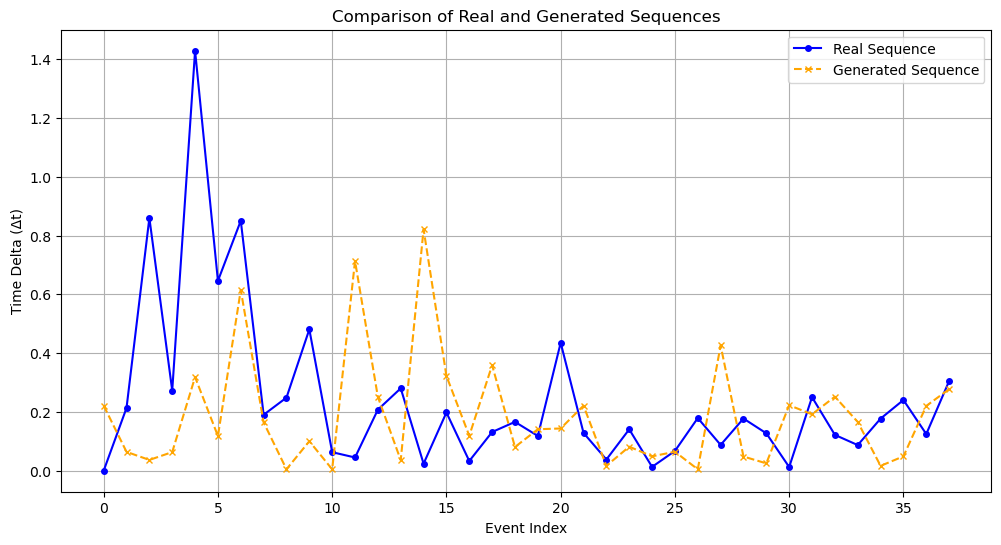

{'type_seqs': [9, 5, 9, 7, 6, 4, 5, 5, 8, 3, 7, 0, 6, 1, 5, 8, 0, 1, 7, 2, 4, 9, 8, 0, 2, 1, 6, 2, 5, 2, 5, 8, 9, 1, 5, 5, 7, 6], 'time_delta_seqs': [0.22151674330234528, 0.06413629651069641, 0.03668539226055145, 0.06337787955999374, 0.31838926672935486, 0.11808650195598602, 0.6146610975265503, 0.1643255203962326, 0.004900315776467323, 0.1003129631280899, 0.004896188620477915, 0.7133012413978577, 0.25099125504493713, 0.03600195050239563, 0.821277379989624, 0.3222898840904236, 0.11896224319934845, 0.35883399844169617, 0.0806722566485405, 0.14107635617256165, 0.14371122419834137, 0.22135302424430847, 0.016711348667740822, 0.08179087936878204, 0.048900097608566284, 0.06459314376115799, 0.004854911472648382, 0.42596256732940674, 0.04828885570168495, 0.025043906643986702, 0.22271256148815155, 0.19197770953178406, 0.2518426179885864, 0.165893092751503, 0.016507858410477638, 0.04893071576952934, 0.22039712965488434, 0.2775824964046478], 'time_seqs': [0.22151674330234528, 0.2856530398130417, 0

In [11]:
def plot_sequences(real_sequence, generated_sequence, title):
    real_delta = real_sequence['time_delta_seqs']
    gen_delta = generated_sequence['time_delta_seqs']

    real_idx = list(range(len(real_delta)))
    gen_idx = list(range(len(gen_delta)))

    plt.figure(figsize=(12, 6))
    plt.plot(real_idx, real_delta, 'o-', label="Real Sequence", color='blue', markersize=4)
    plt.plot(gen_idx, gen_delta, 'x--', label="Generated Sequence", color='orange', markersize=4)
    plt.xlabel("Event Index")
    plt.ylabel("Time Delta (Δt)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

real_sequence = real_sequences[0] 
generated_sequence = generator(
    (torch.tensor(real_sequence['type_seqs'][0]), torch.tensor(real_sequence['time_delta_seqs'][0])), max_len=len(real_sequence['type_seqs'])
)
plot_sequences(real_sequence, generated_sequence, "Comparison of Real and Generated Sequences")
print(generated_sequence)

# Transfer Learning, from GAN to Predictor.

## Define the predictor.

In [ ]:
class RMTPPPredictorStepwise(nn.Module):
    def __init__(self, generator):
        super(RMTPPPredictorStepwise, self).__init__()
        self.hidden_size = generator.hidden_size
        self.num_event_types = generator.num_event_types

        self.layer_rnn = generator.layer_rnn
        self.hidden_to_event_logits = generator.hidden_to_event_logits
        self.layer_temporal_emb = generator.layer_temporal_emb
        self.layer_type_emb = generator.layer_type_emb
        self.hidden_to_intensity_logits = generator.hidden_to_intensity_logits
        self.b_t = generator.b_t
        self.w_t = generator.w_t

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_event_types)  
        )

        for param in [
            *self.layer_rnn.parameters(),
            *self.hidden_to_event_logits.parameters(),
            *self.layer_temporal_emb.parameters(),
            *self.layer_type_emb.parameters(),
            *self.hidden_to_intensity_logits.parameters(),
            self.b_t,
            self.w_t
        ]:
            param.requires_grad = False

    def forward(self, real_sequence, max_len=38, num_samples=1000):

        type_seqs = real_sequence['type_seqs']
        time_delta_seqs = real_sequence['time_delta_seqs']

        batch_size = type_seqs.size(0)
        hidden_states = []
        hidden_state = torch.zeros(1, batch_size, self.hidden_size)
        hidden_states.append(hidden_state.squeeze(0)) 
        for t in range(type_seqs.size(1)):
            type_emb = self.layer_type_emb(type_seqs[:, t])  
            time_emb = self.layer_temporal_emb(time_delta_seqs[:, t].view(-1, 1))  
            combined_emb = (type_emb + time_emb).unsqueeze(1)  
            _, hidden_state = self.layer_rnn(combined_emb, hidden_state)
            hidden_states.append(hidden_state.squeeze(0)) 

        hidden_states = torch.stack(hidden_states, dim=1)  

        current_time = torch.zeros(batch_size)
        predicted_sequence = {
            'type_seqs': [type_seqs[:, 0]], 
            'time_delta_seqs': [time_delta_seqs[:, 0]], 
            'time_seqs': [time_delta_seqs[:, 0]]
        }
        first_logits = torch.zeros(batch_size, self.num_event_types)
        first_logits.scatter_(1, type_seqs[:, 0].unsqueeze(1), 1) 
        logits = [first_logits]
        
        for t in range(1, max_len):
            current_hidden_state = hidden_states[:, t] if t < hidden_states.size(1) else hidden_state.squeeze(0)

            logit = self.classifier(current_hidden_state)  
            logits.append(logit)
            event_type = torch.multinomial(logit.softmax(dim=-1), num_samples=1).squeeze(-1)

            num_samples = 2000  
            base_times = torch.linspace(0, 1, num_samples // 2)
            small_dts = 0.001 + base_times ** 2 * 1.0  
            large_dts = 1.0 + base_times ** 1.5 * 5.0  
            sampled_dts = torch.cat([small_dts, large_dts]).view(-1, 1)
            sampled_dts, _ = torch.sort(sampled_dts) 
            
            hidden_influence = self.hidden_to_intensity_logits(current_hidden_state) 
            intensity_logits = hidden_influence + self.w_t * sampled_dts + self.b_t
            lambdas = torch.exp(intensity_logits.clamp(max=math.log(1e3), min=math.log(1e-3)))  
            delta_t_steps = sampled_dts[1:] - sampled_dts[:-1]
            avg_lambdas = (lambdas[1:] + lambdas[:-1]) / 2
            cdf = torch.cumsum(avg_lambdas.squeeze(-1) * delta_t_steps.squeeze(-1), dim=0)
            cdf = torch.cat([torch.zeros(1, device=cdf.device), cdf]) 
            U = torch.rand(1) ** 1.5  
            target_intensity = -torch.log(1 - U)
            delta_t_idx = torch.searchsorted(cdf, target_intensity)
            delta_t_idx = torch.clamp(delta_t_idx, max=len(sampled_dts)-1)
            delta_t = sampled_dts[delta_t_idx].squeeze()
            small_noise = torch.randn(1) * 0.01 * delta_t
            delta_t = torch.clamp(delta_t + small_noise, min=1e-3) 
            current_time += delta_t.item()

            predicted_sequence['type_seqs'].append(event_type)
            predicted_sequence['time_delta_seqs'].append(delta_t.view(-1))
            predicted_sequence['time_seqs'].append(current_time)

        for key in predicted_sequence.keys():
            predicted_sequence[key] = torch.stack(predicted_sequence[key], dim=1)  # [batch_size, max_len]
        logits = torch.stack(logits, dim=1)  # [batch_size, max_len, num_event_types]

        return predicted_sequence, logits

## Train the Event Type predictor.

In [ ]:
def train_classifier(predictor, train_loader, optimizer, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    predictor.train() 

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch in train_loader:
            real_type_seqs = batch['type_seqs']  
            real_time_delta_seqs = batch['time_delta_seqs']  

            batch_size = real_type_seqs.size(0)

            for i in range(batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0), 
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0) 
                }

                optimizer.zero_grad()

                _, logits = predictor(single_sequence) 

                loss = criterion(logits.view(-1, logits.size(-1)), single_sequence['type_seqs'].view(-1))
                loss.backward()
                optimizer.step()

                predictions = logits.argmax(dim=-1) 
                correct = (predictions == single_sequence['type_seqs']).sum().item()
                total_correct += correct
                total_samples += single_sequence['type_seqs'].numel()
                total_loss += loss.item()

        accuracy = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
generator = RMTPPGenerator(model_config)
generator.load_state_dict(torch.load("generator_try.pth"))

predictor = RMTPPPredictorStepwise(generator)

optimizer = torch.optim.Adam(predictor.classifier.parameters(), lr=1e-3)

C:\Users\14857\AppData\Local\Temp\ipykernel_31252\2218460559.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_try.pth"))


# Test the Effect and Evaluate the performance.

C:\Users\14857\AppData\Local\Temp\ipykernel_31252\795677658.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_type_seqs = torch.tensor(batch['type_seqs'])  # [batch_size, seq_len]
C:\Users\14857\AppData\Local\Temp\ipykernel_31252\795677658.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])  # [batch_size, seq_len]


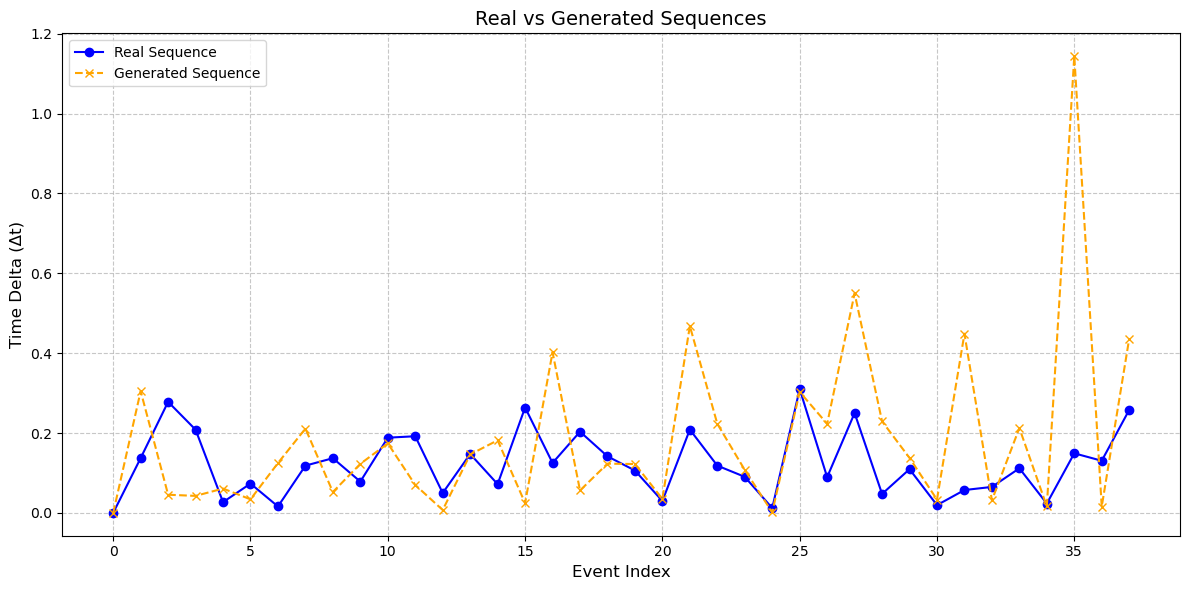

In [ ]:
def plot_sequences(real_sequence, generated_sequence, title="Real vs Generated Sequences"):
    real_delta = real_sequence['time_delta_seqs'].squeeze(0)
    gen_delta = generated_sequence['time_delta_seqs'].squeeze(0)

    real_idx = list(range(38))

    plt.figure(figsize=(12, 6))
    plt.plot(real_idx, real_delta, 'o-', label="Real Sequence", color='blue', markersize=6)
    plt.plot(real_idx, gen_delta, 'x--', label="Generated Sequence", color='orange', markersize=6)
    
    plt.xlabel("Event Index", fontsize=12)
    plt.ylabel("Time Delta (Δt)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()
    
with torch.no_grad():
        for batch in test_loader:
            real_type_seqs = torch.tensor(batch['type_seqs'])  
            real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])

            batch_size, seq_len = real_type_seqs.shape

            for i in range(batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0),  
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0)  
                }
                predicted_sequence,_ = predictor(single_sequence, max_len=seq_len)
                break
plot_sequences(single_sequence, predicted_sequence)

In [ ]:
train_classifier(predictor, train_loader, optimizer, num_epochs=10)

Epoch 1/10, Loss: 567.0880, Accuracy: 0.8957
Epoch 2/10, Loss: 540.9702, Accuracy: 0.9021
Epoch 3/10, Loss: 538.0369, Accuracy: 0.9023
Epoch 4/10, Loss: 535.3836, Accuracy: 0.9034
Epoch 5/10, Loss: 532.7539, Accuracy: 0.9034
Epoch 6/10, Loss: 533.0411, Accuracy: 0.9033
Epoch 7/10, Loss: 531.1481, Accuracy: 0.9042
Epoch 8/10, Loss: 530.2119, Accuracy: 0.9040
Epoch 9/10, Loss: 528.7669, Accuracy: 0.9040
Epoch 10/10, Loss: 528.7971, Accuracy: 0.9044


In [ ]:
torch.save(predictor.state_dict(), "predictor.pth")

C:\Users\14857\AppData\Local\Temp\ipykernel_31252\795677658.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_type_seqs = torch.tensor(batch['type_seqs'])  # [batch_size, seq_len]
C:\Users\14857\AppData\Local\Temp\ipykernel_31252\795677658.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])  # [batch_size, seq_len]


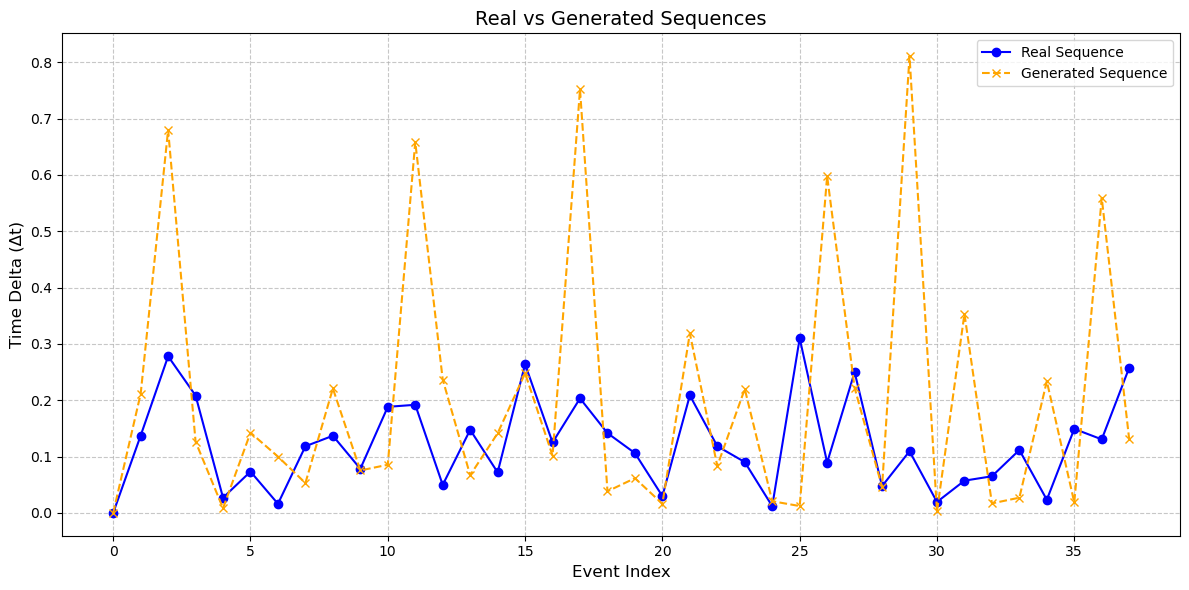

In [ ]:
def plot_sequences(real_sequence, generated_sequence, title="Real vs Generated Sequences"):
    real_delta = real_sequence['time_delta_seqs'].squeeze(0)
    gen_delta = generated_sequence['time_delta_seqs'].squeeze(0)

    real_idx = list(range(38))

    plt.figure(figsize=(12, 6))
    plt.plot(real_idx, real_delta, 'o-', label="Real Sequence", color='blue', markersize=6)
    plt.plot(real_idx, gen_delta, 'x--', label="Generated Sequence", color='orange', markersize=6)

    plt.xlabel("Event Index", fontsize=12)
    plt.ylabel("Time Delta (Δt)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()
    
with torch.no_grad():
        for batch in test_loader:
            real_type_seqs = torch.tensor(batch['type_seqs']) 
            real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])

            batch_size, seq_len = real_type_seqs.shape
            for i in range(batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0),
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0) 
                }
                predicted_sequence,_ = predictor(single_sequence, max_len=seq_len)
                break
plot_sequences(single_sequence, predicted_sequence)

In [ ]:
def evaluate_model(predictor, test_loader):
    total_correct = 0
    total_events = 0
    total_squared_error = 0
    total_time_steps = 0

    predictor.eval() 
    with torch.no_grad():
        for batch in test_loader:
            real_type_seqs = torch.tensor(batch['type_seqs']) 
            real_time_delta_seqs = torch.tensor(batch['time_delta_seqs']) 

            batch_size, seq_len = real_type_seqs.shape

            for i in range(batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0), 
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0)  
                }
                predicted_sequence,_ = predictor(single_sequence, max_len=seq_len)

                predicted_type_seqs = predicted_sequence['type_seqs'].squeeze(0) 
                predicted_time_delta_seqs = predicted_sequence['time_delta_seqs'].squeeze(0)

                correct_predictions = (predicted_type_seqs == real_type_seqs[i]).sum().item()
                total_correct += correct_predictions
                total_events += seq_len

                squared_error = ((predicted_time_delta_seqs - real_time_delta_seqs[i]) ** 2).sum().item()
                total_squared_error += squared_error
                total_time_steps += seq_len

    accuracy = total_correct / total_events
    rmse = math.sqrt(total_squared_error / total_time_steps)

    return accuracy, rmse

accuracy, rmse = evaluate_model(predictor, test_loader)
print(f"Event Type Accuracy: {accuracy:.4f}")
print(f"Time Delta RMSE: {rmse:.4f}")

C:\Users\14857\AppData\Local\Temp\ipykernel_31252\3880758743.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_type_seqs = torch.tensor(batch['type_seqs'])  # [batch_size, seq_len]
C:\Users\14857\AppData\Local\Temp\ipykernel_31252\3880758743.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])  # [batch_size, seq_len]


Event Type Accuracy: 0.8504
Time Delta RMSE: 0.3608
